# DogFaceNet version 4
I hope this one gonna work...

### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K

In [2]:
PATH = '../data/dogfacenet/aligned/after_2/'
PATH_SAVE = '../output/history/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.05

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

3148


In [4]:
# Normalization
images /= 255.0
# images -= 127.5
# images /= 128.0


In [5]:
nbof_classes = len(np.unique(labels))

Open-set: test set

In [6]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train_tmp = images[keep_train]
labels_train_tmp = labels[keep_train]

Closed-set: validation images

In [7]:
labels_train_tmp -= min(labels_train_tmp)
unique = np.unique(labels_train_tmp)


# Compute number of validation images
nbof_valid = 0
for clas in unique:
    labels_class = labels_train_tmp[np.equal(labels_train_tmp,clas)]
    
    nbof_valid += np.ceil(len(labels_class)*VALID_SPLIT)

nbof_valid = int(nbof_valid)
print("Number of validation images: " + str(nbof_valid))

# Fill the arrays
h,w,c = SIZE
images_train = np.empty((len(images_train_tmp)-nbof_valid,h,w,c))
labels_train = np.empty(len(images_train_tmp)-nbof_valid)

images_valid = np.empty((nbof_valid,h,w,c))
labels_valid = np.empty(nbof_valid)

crt_index_valid = 0
crt_index_train = 0

for clas in unique:
    images_class = images_train_tmp[np.equal(labels_train_tmp,clas)]
    labels_class = labels_train_tmp[np.equal(labels_train_tmp,clas)]
    
    nbof_valid_class = int(np.ceil(len(labels_class)*VALID_SPLIT))
    images_valid[crt_index_valid:crt_index_valid+nbof_valid_class] = images_class[:nbof_valid_class]
    labels_valid[crt_index_valid:crt_index_valid+nbof_valid_class] = labels_class[:nbof_valid_class]
    
    crt_index_valid = crt_index_valid+nbof_valid_class
    
    images_train[crt_index_train:crt_index_train+len(labels_class)-nbof_valid_class] = images_class[nbof_valid_class:]
    labels_train[crt_index_train:crt_index_train+len(labels_class)-nbof_valid_class] = labels_class[nbof_valid_class:]
    
    crt_index_train = crt_index_train+len(labels_class)-nbof_valid_class

Number of validation images: 515


In [8]:
labels_train = tf.keras.utils.to_categorical(labels_train, num_classes=len(unique))
labels_valid = tf.keras.utils.to_categorical(labels_valid, num_classes=len(unique))

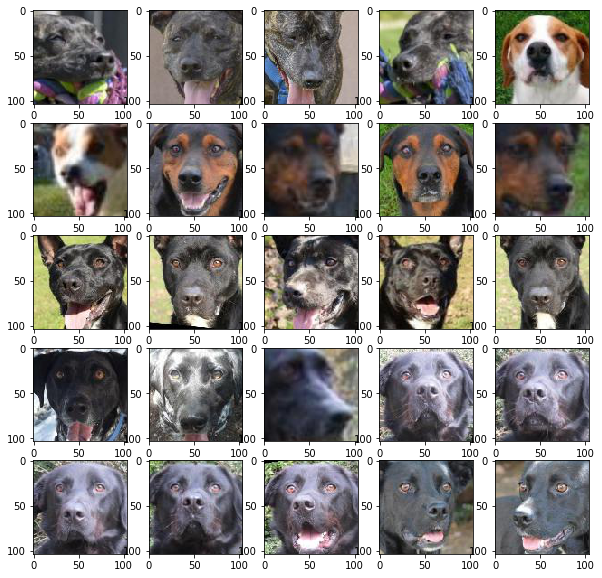

In [9]:
# Test
fig = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_train[i])
    #print(np.argmax(labels_train[i]))

In [10]:
# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    #zca_whitening=True
)
train_datagen.fit(images_train[:10])

### Loss definition

In [11]:
s = 60.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

### Layer definition

In [12]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class Cosine(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

### Model definition

In [15]:
# dogfacenet_v7
out_num = len(unique)

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(104, 104, 3))
x = base_model.layers[8].output
x = MaxPooling2D((2,2))(x)
x = Dropout(0.25)(x)
#x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(18)(x)
predictions = Dense(out_num, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 104, 104, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 104, 104, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 104, 104, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 52, 52, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 52, 52, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 52, 52, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 26, 26, 128)       0         
__________

In [13]:
images_train_pre = tf.keras.applications.vgg16.preprocess_input(images_train)
images_valid_pre = tf.keras.applications.vgg16.preprocess_input(images_valid)

In [16]:
history=model.fit(
    images_train_pre,
    labels_train,
    batch_size = 64,
    epochs = 10,
    validation_data=(images_valid_pre,labels_valid)
)

Train on 814 samples, validate on 138 samples
Epoch 1/10
814/814 [==============================] - ETA: 39s - loss: 16.1181 - acc: 0.0000e+0 - ETA: 22s - loss: 15.9922 - acc: 0.0078    - ETA: 16s - loss: 16.0341 - acc: 0.005 - ETA: 12s - loss: 15.9922 - acc: 0.007 - ETA: 10s - loss: 15.9670 - acc: 0.009 - ETA: 8s - loss: 15.9922 - acc: 0.007 - ETA: 6s - loss: 16.0102 - acc: 0.00 - ETA: 5s - loss: 16.0237 - acc: 0.00 - ETA: 4s - loss: 16.0062 - acc: 0.00 - ETA: 2s - loss: 16.0174 - acc: 0.00 - ETA: 1s - loss: 16.0265 - acc: 0.00 - ETA: 0s - loss: 16.0132 - acc: 0.00 - 15s 18ms/step - loss: 15.9795 - acc: 0.0086 - val_loss: 16.0013 - val_acc: 0.0072
Epoch 2/10
814/814 [==============================] - ETA: 9s - loss: 16.1181 - acc: 0.0000e+ - ETA: 8s - loss: 15.9922 - acc: 0.0078   - ETA: 7s - loss: 15.9502 - acc: 0.01 - ETA: 6s - loss: 15.9922 - acc: 0.00 - ETA: 6s - loss: 16.0174 - acc: 0.00 - ETA: 5s - loss: 16.0341 - acc: 0.00 - ETA: 4s - loss: 16.0461 - acc: 0.00 - ETA: 3s - loss:

ResourceExhaustedError: OOM when allocating tensor with shape[64,64,104,104] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/RMSprop/gradients/block1_conv2_1/Conv2D_grad/Conv2DBackpropInput}} = Conv2DBackpropInput[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/RMSprop/gradients/block1_conv2_1/Conv2D_grad/ShapeN, block1_conv2_1/Conv2D/ReadVariableOp, training_1/RMSprop/gradients/block1_conv2_1/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


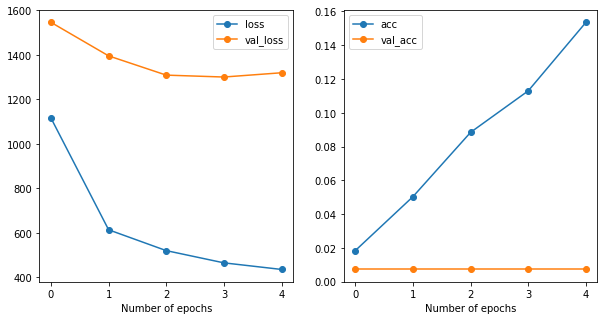

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.01.31.dogfacenet_v8.resnet50.cosine.s_30.m_0.1.npy',history_)
np.savetxt(PATH_SAVE+'2018.01.31.dogfacenet_v8.resnet50.cosine.s_30.m_0.1.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [12]:
# dogfacenet_v6
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Cosine(out_num))

model.compile(loss=cosine,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 102, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
__________

In [33]:
# dogfacenet_v6_softmax
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Dense(out_num, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 102, 102, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 128)       0         
__________

In [13]:
# dogfacenet_v4
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(104, 104, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Cosine(out_num))

model.compile(loss=cosine,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 102, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 102, 102, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 256)       147712    
_________________________________________________________________
activation_1 (Activation)    (None, 49, 49, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 512)       1180160   
__________

In [15]:
history=model.fit(
    images_train,
    labels_train,
    batch_size = 64,
    epochs = 15,
    validation_data=(images_valid,labels_valid)
)

Train on 2498 samples, validate on 515 samples
Epoch 1/15
2498/2498 [==============================] - ETA: 14s - loss: 972.5374 - acc: 0.60 - ETA: 13s - loss: 1077.6331 - acc: 0.515 - ETA: 13s - loss: 1070.9588 - acc: 0.536 - ETA: 12s - loss: 1057.9238 - acc: 0.554 - ETA: 12s - loss: 1069.3948 - acc: 0.546 - ETA: 11s - loss: 1079.3511 - acc: 0.549 - ETA: 11s - loss: 1061.6386 - acc: 0.560 - ETA: 11s - loss: 1075.9399 - acc: 0.556 - ETA: 10s - loss: 1070.4363 - acc: 0.560 - ETA: 10s - loss: 1058.2228 - acc: 0.570 - ETA: 10s - loss: 1053.5138 - acc: 0.572 - ETA: 9s - loss: 1039.1382 - acc: 0.582 - ETA: 9s - loss: 1038.1324 - acc: 0.58 - ETA: 8s - loss: 1037.7131 - acc: 0.58 - ETA: 8s - loss: 1039.7691 - acc: 0.57 - ETA: 8s - loss: 1036.0402 - acc: 0.58 - ETA: 7s - loss: 1038.2661 - acc: 0.58 - ETA: 7s - loss: 1033.9186 - acc: 0.57 - ETA: 7s - loss: 1039.5027 - acc: 0.57 - ETA: 6s - loss: 1046.3135 - acc: 0.57 - ETA: 6s - loss: 1039.4756 - acc: 0.57 - ETA: 6s - loss: 1038.3470 - acc: 0.5

KeyboardInterrupt: 

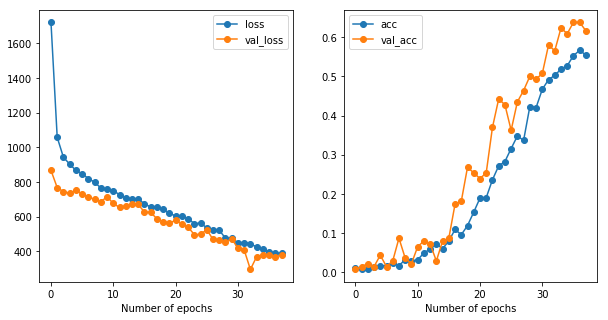

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.01.data_aug.dogfacenet_v6.cosine_2.s_60.m_0.1.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.01.data_aug.dogfacenet_v6.cosine_2.s_60.m_0.1.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [14]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/12
40/40 [==============================] - ETA: 6:40 - loss: 3033.9841 - acc: 0.0000e+ - ETA: 3:20 - loss: 3193.7477 - acc: 0.0078   - ETA: 2:14 - loss: 3131.7262 - acc: 0.00 - ETA: 1:41 - loss: 3100.9213 - acc: 0.00 - ETA: 1:21 - loss: 3011.6771 - acc: 0.01 - ETA: 1:07 - loss: 2969.4160 - acc: 0.01 - ETA: 57s - loss: 2898.0631 - acc: 0.0089 - ETA: 50s - loss: 2821.5505 - acc: 0.007 - ETA: 44s - loss: 2773.2350 - acc: 0.006 - ETA: 39s - loss: 2718.2655 - acc: 0.006 - ETA: 35s - loss: 2673.9746 - acc: 0.005 - ETA: 32s - loss: 2639.0772 - acc: 0.005 - ETA: 29s - loss: 2607.5262 - acc: 0.004 - ETA: 27s - loss: 2588.1751 - acc: 0.004 - ETA: 24s - loss: 2556.4133 - acc: 0.004 - ETA: 22s - loss: 2525.0515 - acc: 0.004 - ETA: 21s - loss: 2379.7240 - acc: 0.004 - ETA: 19s - loss: 2365.8392 - acc: 0.004 - ETA: 18s - loss: 2358.0670 - acc: 0.004 - ETA: 16s - loss: 2344.6071 - acc: 0.004 - ETA: 15s - loss: 2334.9984 - acc: 0.004 - ETA: 14s - loss: 2315.3236 - acc: 0.004 - ETA: 13s - loss

40/40 [==============================] - ETA: 13s - loss: 1621.3070 - acc: 0.0000e+0 - ETA: 12s - loss: 1622.9531 - acc: 0.0078    - ETA: 12s - loss: 1614.6364 - acc: 0.005 - ETA: 11s - loss: 1619.5349 - acc: 0.003 - ETA: 11s - loss: 1623.8907 - acc: 0.003 - ETA: 11s - loss: 1623.7656 - acc: 0.005 - ETA: 10s - loss: 1621.6801 - acc: 0.004 - ETA: 10s - loss: 1620.6363 - acc: 0.003 - ETA: 10s - loss: 1616.8066 - acc: 0.005 - ETA: 9s - loss: 1623.4149 - acc: 0.004 - ETA: 8s - loss: 1493.1102 - acc: 0.00 - ETA: 8s - loss: 1504.0051 - acc: 0.00 - ETA: 8s - loss: 1513.7397 - acc: 0.00 - ETA: 7s - loss: 1523.1900 - acc: 0.00 - ETA: 7s - loss: 1529.9574 - acc: 0.00 - ETA: 7s - loss: 1537.1782 - acc: 0.00 - ETA: 6s - loss: 1542.7510 - acc: 0.00 - ETA: 6s - loss: 1547.5601 - acc: 0.00 - ETA: 6s - loss: 1551.1709 - acc: 0.00 - ETA: 6s - loss: 1556.2143 - acc: 0.00 - ETA: 5s - loss: 1559.1931 - acc: 0.00 - ETA: 5s - loss: 1561.2826 - acc: 0.00 - ETA: 5s - loss: 1563.5755 - acc: 0.00 - ETA: 4s - lo

40/40 [==============================] - ETA: 12s - loss: 1553.2555 - acc: 0.046 - ETA: 11s - loss: 1557.4442 - acc: 0.023 - ETA: 11s - loss: 1559.9218 - acc: 0.020 - ETA: 11s - loss: 1564.8853 - acc: 0.019 - ETA: 11s - loss: 1560.9692 - acc: 0.021 - ETA: 10s - loss: 1562.4371 - acc: 0.020 - ETA: 10s - loss: 1563.6058 - acc: 0.017 - ETA: 10s - loss: 1563.6732 - acc: 0.019 - ETA: 9s - loss: 1562.8299 - acc: 0.019 - ETA: 9s - loss: 1560.2613 - acc: 0.02 - ETA: 9s - loss: 1559.2021 - acc: 0.02 - ETA: 9s - loss: 1559.6456 - acc: 0.02 - ETA: 8s - loss: 1559.8105 - acc: 0.02 - ETA: 8s - loss: 1562.1020 - acc: 0.02 - ETA: 8s - loss: 1564.2353 - acc: 0.02 - ETA: 7s - loss: 1473.9175 - acc: 0.01 - ETA: 6s - loss: 1479.2918 - acc: 0.01 - ETA: 6s - loss: 1484.0584 - acc: 0.01 - ETA: 6s - loss: 1487.1040 - acc: 0.01 - ETA: 5s - loss: 1490.0914 - acc: 0.02 - ETA: 5s - loss: 1493.1654 - acc: 0.02 - ETA: 5s - loss: 1496.8550 - acc: 0.02 - ETA: 5s - loss: 1499.7177 - acc: 0.02 - ETA: 4s - loss: 1503.3

In [41]:
model.save('../output/model/dogfacenet_v6_cosine.h5')

In [26]:
def net(input_shape, emb_size=4):
    input_image = tf.keras.Input(input_shape,name='image_input')
    
    x = tf.keras.layers.Conv2D(64, (3,3), strides=(3,3), activation='relu', padding='same')(input_image)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(256, (3,3), strides=(3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(512, (3,3), strides=(3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    #x = tf.keras.layers.Dense(128, activation='relu')(x)
    #out = Cosine(out_num, name='output')(x)
    out = tf.keras.layers.Dense(out_num, activation='softmax', name='output')(x)
    
    model = tf.keras.Model(inputs=[input_image], outputs=out)
    return model

w, h, c = SIZE
input_shape = (w, h, c,)
model = net(input_shape)
model.compile(tf.keras.optimizers.Adam(),loss={'output':'categorical_crossentropy'},metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 104, 104, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 35, 64)        1792      
_________________________________________________________________
dropout_4 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       147712    
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 512)         1180160   
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 512)         0         
__________

### Train it

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-5),
              metrics=['accuracy'])

In [18]:
model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 50,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/50


c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/13 [==============================] - ETA: 1:29 - loss: 4.8474 - acc: 0.0000e+0 - ETA: 41s - loss: 4.8427 - acc: 0.0156    - ETA: 25s - loss: 4.8440 - acc: 0.01 - ETA: 17s - loss: 4.8413 - acc: 0.01 - ETA: 12s - loss: 4.8375 - acc: 0.01 - ETA: 9s - loss: 4.8348 - acc: 0.0140 - ETA: 6s - loss: 4.8315 - acc: 0.016 - ETA: 5s - loss: 4.8274 - acc: 0.014 - ETA: 3s - loss: 4.8269 - acc: 0.018 - ETA: 2s - loss: 4.8270 - acc: 0.020 - ETA: 1s - loss: 4.8270 - acc: 0.021 - ETA: 0s - loss: 4.8276 - acc: 0.021 - 9s 674ms/step - loss: 4.8283 - acc: 0.0221 - val_loss: 4.8029 - val_acc: 0.0290
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 4.7678 - acc: 0.062 - ETA: 0s - loss: 4.7703 - acc: 0.039 - ETA: 0s - loss: 4.7796 - acc: 0.031 - ETA: 1s - loss: 4.7835 - acc: 0.027 - ETA: 0s - loss: 4.7769 - acc: 0.031 - ETA: 0s - loss: 4.7819 - acc: 0.026 - ETA: 0s - loss: 4.7791 - acc: 0.026 - ETA: 0s - loss: 4.7824 - acc: 0.027 - ETA: 0s - loss: 4.7803 - acc: 0.024 - ETA: 0s - loss: 4

Epoch 15/50
13/13 [==============================] - ETA: 1s - loss: 4.5012 - acc: 0.125 - ETA: 1s - loss: 4.4540 - acc: 0.125 - ETA: 1s - loss: 4.4515 - acc: 0.125 - ETA: 1s - loss: 4.4257 - acc: 0.148 - ETA: 1s - loss: 4.4377 - acc: 0.140 - ETA: 1s - loss: 4.4397 - acc: 0.140 - ETA: 0s - loss: 4.4405 - acc: 0.147 - ETA: 0s - loss: 4.4501 - acc: 0.144 - ETA: 0s - loss: 4.4489 - acc: 0.147 - ETA: 0s - loss: 4.4454 - acc: 0.150 - ETA: 0s - loss: 4.4487 - acc: 0.149 - ETA: 0s - loss: 4.4516 - acc: 0.145 - 2s 172ms/step - loss: 4.4499 - acc: 0.1480 - val_loss: 4.3780 - val_acc: 0.1594
Epoch 16/50
13/13 [==============================] - ETA: 2s - loss: 4.4242 - acc: 0.156 - ETA: 2s - loss: 4.4119 - acc: 0.156 - ETA: 1s - loss: 4.4161 - acc: 0.166 - ETA: 1s - loss: 4.4338 - acc: 0.164 - ETA: 1s - loss: 4.4340 - acc: 0.175 - ETA: 1s - loss: 4.4467 - acc: 0.161 - ETA: 1s - loss: 4.4539 - acc: 0.151 - ETA: 1s - loss: 4.4572 - acc: 0.152 - ETA: 0s - loss: 4.4554 - acc: 0.152 - ETA: 0s - loss: 

KeyboardInterrupt: 

In [49]:
model.save('../output/model/small_net_2.h5')

In [28]:
model.fit(
    images_train,
    labels_train,
    batch_size = 32,
    epochs = 2,
    validation_data=(images_valid,labels_valid)
)

Train on 814 samples, validate on 138 samples
Epoch 1/2
814/814 [==============================] - ETA: 1s - loss: 2.3361 - acc: 0.375 - ETA: 1s - loss: 2.4099 - acc: 0.359 - ETA: 1s - loss: 2.2265 - acc: 0.437 - ETA: 1s - loss: 2.1851 - acc: 0.453 - ETA: 1s - loss: 2.1018 - acc: 0.474 - ETA: 1s - loss: 2.0683 - acc: 0.473 - ETA: 0s - loss: 2.1446 - acc: 0.472 - ETA: 0s - loss: 2.1126 - acc: 0.475 - ETA: 0s - loss: 2.1189 - acc: 0.471 - ETA: 0s - loss: 2.1302 - acc: 0.463 - ETA: 0s - loss: 2.1160 - acc: 0.464 - ETA: 0s - loss: 2.1321 - acc: 0.466 - ETA: 0s - loss: 2.1372 - acc: 0.467 - ETA: 0s - loss: 2.1268 - acc: 0.471 - ETA: 0s - loss: 2.1170 - acc: 0.474 - ETA: 0s - loss: 2.1291 - acc: 0.470 - ETA: 0s - loss: 2.1637 - acc: 0.466 - 2s 2ms/step - loss: 2.1660 - acc: 0.4656 - val_loss: 2.1854 - val_acc: 0.5507
Epoch 2/2
814/814 [==============================] - ETA: 1s - loss: 1.7001 - acc: 0.531 - ETA: 1s - loss: 1.5022 - acc: 0.640 - ETA: 1s - loss: 1.4993 - acc: 0.645 - ETA: 1s - 

In [29]:
model.save('../output/model/net.h5')

### Evaluate it

#### Evaluate on validation

In [16]:
pred = model.predict(images_valid)

In [17]:
print([np.argmax(pred[i]) for i in range(16)])
print([np.argmax(labels_valid[i]) for i in range(16)])
print(np.sum(np.equal(np.argmax(pred, axis=1),np.argmax(labels_valid, axis=1)).astype(float))/len(pred))

[76, 1, 2, 3, 30, 5, 76, 90, 8, 9, 10, 429, 12, 349, 338, 287]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
0.49514563106796117


[ True  True  True  True  True]


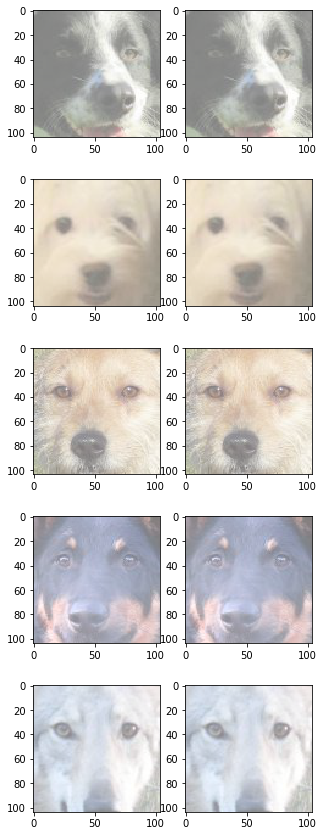

In [17]:
n = 5
s = 100
y_true = np.argmax(labels_valid, axis=1)
y_pred = np.argmax(pred, axis=1)
print(np.equal(y_true,y_pred)[s:5+s])
fig = plt.figure(figsize=(5,3*5))
for i in range(0,10,2):
    plt.subplot(5,2,i+1)
    plt.imshow(images_valid[i//2 + s]*0.5+0.5)
    plt.subplot(5,2,i+2)
    image_pred = images_valid[np.equal(y_true,np.argmax(pred[i//2 + s]))][0]
    plt.imshow(image_pred*0.5+0.5)

#### Evaluate on verification task

In [18]:
# Create pairs
h,w,c = SIZE
pairs = np.empty((len(images_test)*2,h,w,c))
issame = np.empty(len(images_test))
class_test = np.unique(labels_test)
for i in range(len(images_test)):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

[1. 1. 1. 1. 1.]


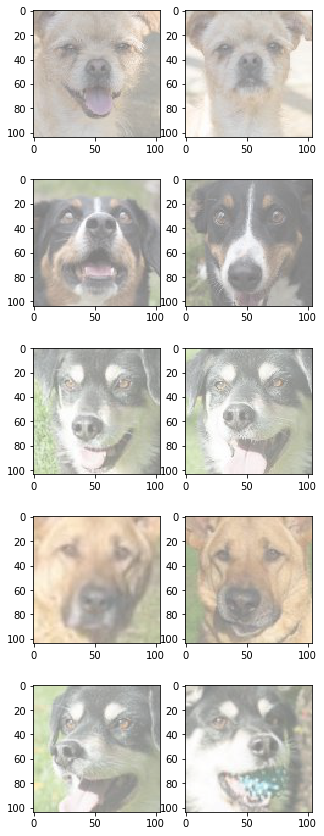

In [19]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [20]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-2].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
# diff = np.square(emb1-emb2)
# dist = np.sum(diff,1)

# Compute the angle between pairs
dist = np.sum(emb1*emb2,1)

best = 0
best_t = 0
thresholds = np.arange(0.0001,2,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

Best threshold: 0.0001
Best accuracy: 0.35555555555555557


### Observation on the heatmap

In [40]:
model.layers

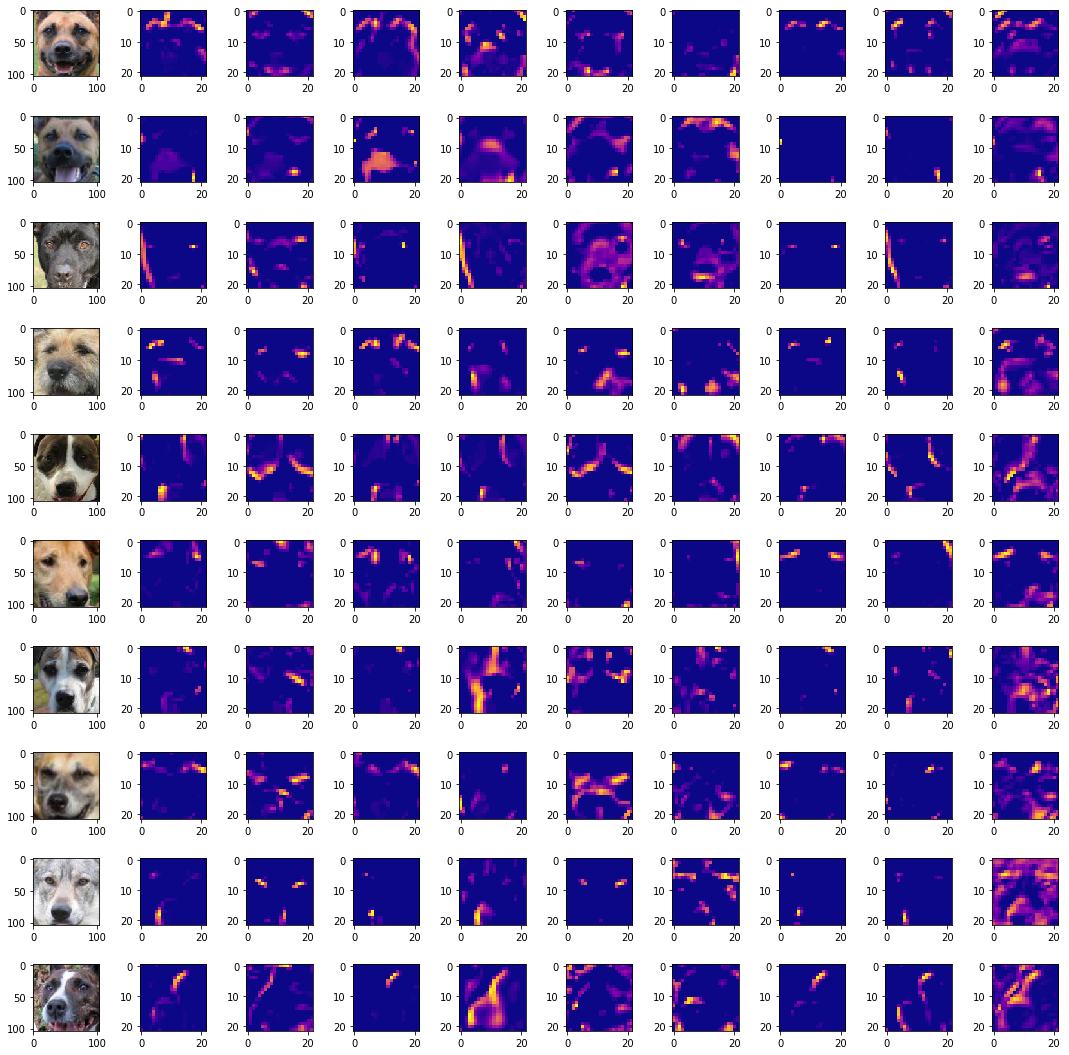

In [24]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[7].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

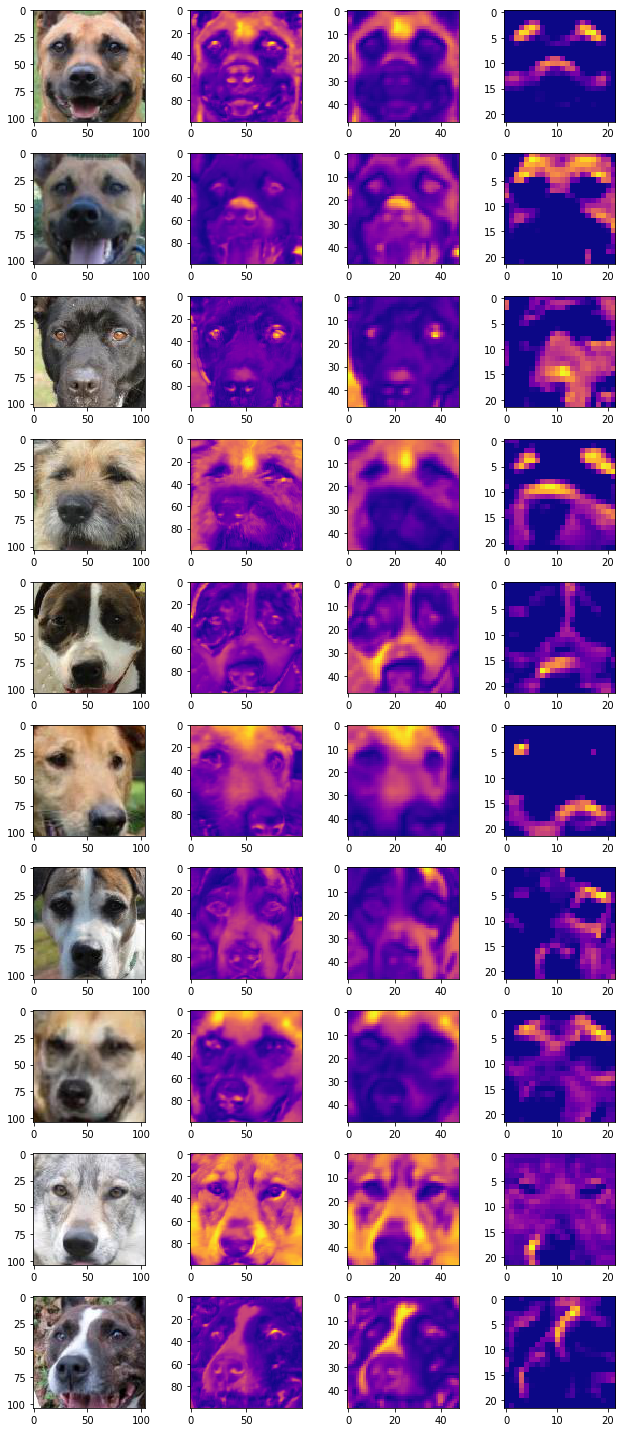

In [29]:
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0:100:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[4].output)
predict2 = mod2.predict(images_train[0:100:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[7].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

## Archives:

In [10]:
from tensorflow.keras import backend as K

m = 0.5
s = 64.
out_num = len(unique)

print("Number of outputs: " + str(out_num))

def cosineLoss(y_true,y_pred):
    # Compute the softmax like 
    e_s_m = K.exp(s*y_pred - m)
    e_s = K.exp(s*y_pred)
    
    mask = K.cast(y_true, tf.float32)
    inv_mask = 1. - mask
    den = e_s_m * mask + e_s * inv_mask
    den = K.sum(den,-1,keepdims=True)

    out = e_s_m / den
    # Compute the categorical crossentropy
    return K.categorical_crossentropy(y_true,out)

Number of outputs: 125


In [11]:
from tensorflow.keras import backend as K

m = 0.5
s = 64.
out_num = len(unique)

print("Number of outputs: " + str(out_num))

def stand(y_true,y_pred):
    # Compute the softmax like 
    e = K.exp(y_pred - K.max(y_pred, axis=-1, keepdims=True))
    s = K.sum(e, axis=-1, keepdims=True)

    out = e / s
    # Compute the categorical crossentropy
    return K.categorical_crossentropy(y_true,out)

Number of outputs: 125


In [12]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class Cosine(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = x / tf.norm(x,axis=-1,keepdims=True)
        w = self.kernel / tf.norm(self.kernel,axis=0,keepdims=True)
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [12]:
def net(input_shape, emb_size=4):
    input_image = tf.keras.Input(input_shape,name='image_input')
    
    x = tf.keras.layers.Conv2D(32, (5,5), padding='same')(input_image)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Concatenate()([input_image,x])
    
    r = tf.keras.layers.MaxPooling2D((3,3))(x)
    
    x = tf.keras.layers.Dropout(0.25)(r)
    
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Concatenate()([r,x])
    
    r = tf.keras.layers.MaxPooling2D((3,3))(x)
    
    x = tf.keras.layers.Dropout(0.25)(r)
    
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Concatenate()([r,x])
    
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
#     emb = tf.keras.layers.Dense(10, activity_regularizer='l2')(x)
#     out = tf.keras.layers.Dense(out_num, kernel_regularizer='l2', use_bias=False, name='output')(emb)
    
#     out = tf.keras.layers.Dense(out_num, activation='softmax', name='output')(x)

    #emb = tf.keras.layers.Dense(, activation='relu')(x)
    out = Cosine(out_num, name='output')(x)
    
    model = tf.keras.Model(inputs=[input_image], outputs=out)
    return model

w, h, c = SIZE
input_shape = (w, h, c,)
model = net(input_shape)
model.compile(tf.keras.optimizers.Adam(),loss={'output':cosineLoss},metrics=['accuracy'])
#model.summary()

In [42]:
# Best model I obtained: 60% precision on the validation set

out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(104, 104, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(out_num))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

model.fit(
    images_train,
    labels_train,
    batch_size = 64,
    epochs = 30,
    validation_data=(images_valid,labels_valid)
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 102, 102, 32)      896       
_________________________________________________________________
activation_53 (Activation)   (None, 102, 102, 32)      0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 51, 51, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 49, 49, 32)        9248      
_________________________________________________________________
activation_54 (Activation)   (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 22, 22, 64)        18496     
__________

In [ ]:
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(104, 104, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Cosine(out_num))

model.compile(loss=cosineLoss,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()